In [1]:
import h5py
import numpy as np
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets as datasetsgh
import torchvision.transforms as transforms
from torchsummary import summary
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

import time
import copy
import sys
import random
import gc

In [2]:
### CNN ARCHITECTURE ###
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        
    def forward(self,x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))
        
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((F.interpolate(dec4, size=enc4.size()[2:]), enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((F.interpolate(dec3, size=enc3.size()[2:]), enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((F.interpolate(dec2, size=enc2.size()[2:]), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((F.interpolate(dec1, size=enc1.size()[2:]), enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.output_conv(dec1)
        
        return output

In [3]:
### SETTING GPU AND NETWORK ###
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
in_channels = 1
out_channels = 2
input_size = (1,256,256) 

print("hyperparameters set")

# Initialize network
model = UNet(in_channels, out_channels).to(device)

# Print the model summary
summary(model, input_size=input_size)

Using device: cuda:0
hyperparameters set
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
         MaxPool2d-5         [-1, 64, 128, 128]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]         147,584
              ReLU-9        [-1, 128, 128, 128]               0
        MaxPool2d-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
             ReLU-12          [-1, 256, 64, 64]               0
           Conv2d-13          [-1, 256, 64, 64]         590,08

In [4]:
### CUSTOM DATASET FOR HDF5 FILE ###
class HDF5Dataset:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = h5py.File(self.file_path, 'r')
        self.images = self.file['images'][:]
        self.fractures = self.file['fractures'][:]
        self.streams = self.file['streams'][:]
        self.ids = self.file['ids'][:]
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        fractures = self.fractures[idx]
        streams = self.streams[idx]
        ids = self.ids[idx]
        
        image_tensor = torch.from_numpy(images).unsqueeze(0).float()
        fracture_tensor = torch.from_numpy(fractures).unsqueeze(0).float()
        stream_tensor = torch.from_numpy(streams).unsqueeze(0).float()
        ids_tensor = torch.tensor(ids, dtype=torch.int64)
        
        return {
            'images': image_tensor,
            'fractures': fracture_tensor,
            'streams': stream_tensor,
            'ids': ids_tensor
        }
    
    def __del__(self):
        self.file.close()

In [5]:
### SETTING DATALOADERS ###
batch_size = 64

train_file = "/data/data/datasets/train_dataset.h5"
test_file = "/data/data/datasets/test_dataset.h5"
val_file = "/data/data/datasets/val_dataset.h5"

ds_train = HDF5Dataset(train_file)
ds_test = HDF5Dataset(test_file)
ds_val = HDF5Dataset(val_file)

dataloader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

torch.Size([16, 1, 256, 256])
torch.Size([256, 256])


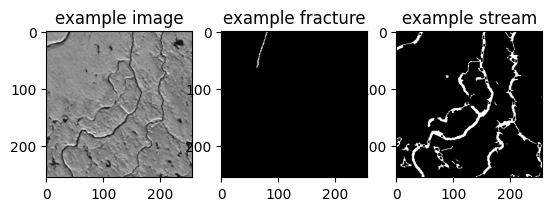

In [7]:
### TESTING DATALOADERS ###
data_iter = iter(dataloader_train)
batch = next(data_iter)

print(batch["images"].shape)

image = batch["images"][0][0]
print(image.shape)
streams = batch["streams"][0][0]
fractures = batch["fractures"][0][0]

plt.subplot(1,3,1)
plt.imshow(np.asarray(image),cmap='gray')
plt.title("example image")
plt.subplot(1,3,2)
plt.title("example fracture")
plt.imshow(np.asarray(fractures),cmap='gray')
plt.subplot(1,3,3)
plt.title("example stream")
plt.imshow(np.asarray(streams),cmap='gray')

In [17]:
learning_rate = 0.001
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def print_existing_tensors():
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(f"Tensor: {obj.size()}, Device: {obj.device}")
                del obj
        except:
            pass

print_existing_tensors()

/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Tensor: torch.Size([64, 1, 3, 3]), Device: cpu
Tensor: torch.Size([64]), Device: cpu
Tensor: torch.Size([64, 64, 3, 3]), Device: cpu
Tensor: torch.Size([64]), Device: cpu
Tensor: torch.Size([128, 64, 3, 3]), Device: cpu
Tensor: torch.Size([128]), Device: cpu
Tensor: torch.Size([128, 128, 3, 3]), Device: cpu
Tensor: torch.Size([128]), Device: cpu
Tensor: torch.Size([256, 128, 3, 3]), Device: cpu
Tensor: torch.Size([256]), Device: cpu
Tensor: torch.Size([256, 256, 3, 3]), Device: cpu
Tensor: torch.Size([256]), Device: cpu
Tensor: torch.Size([1024, 512, 2, 2]), Device: cpu
Tensor: torch.Size([512]), Device: cpu
Tensor: torch.Size([512, 256, 2, 2]), Device: cpu
Tensor: torch.Size([256]), Device: cpu
Tensor: torch.Size([256, 128, 2, 2]), Device: cpu
Tensor: torch.Size([128]), Device: cpu
Tensor: torch.Size([128, 64, 2, 2]), Device: cpu
Tensor: torch.Size([64]), Device: cpu
Tensor: torch.Size([2, 64, 1, 1]), Device: cpu
Tensor: torch.Size([2]), Device: cpu
Tensor: torch.Size([1024, 512, 3, 3

In [18]:
### TRAINING MODEL ###
torch.cuda.empty_cache()
# Wrap the model with DataParallel
model = nn.DataParallel(model)

num_epochs = 100

fracture_train_losses = []
stream_train_losses = []
fracture_val_losses = []
stream_val_losses = []
val_losses = []
train_losses = []

torch.cuda.empty_cache()

best_loss_val = float('inf')  # Initialize with a high value
best_loss_train = float('inf')  # Initialize with a high value


print(f'train size[{len(ds_train)}]; val size[{len(ds_val)}]; batch size[{batch_size}]; batches per epoch[{len(dataloader_train)}]')

# Now use the DataLoader in the training loop
start_time_trainloop = time.time()
for epoch in range(1, num_epochs + 1):
    
    # start epoch timer
    start_time_epoch = time.time() 
    
    train_loss = 0.0
    val_loss = 0.0
    fracture_train_loss = 0.0
    fracture_val_loss = 0.0
    stream_train_loss = 0.0
    stream_val_loss = 0.0
    
    for batch_idx, batch in enumerate(dataloader_train):
        images = batch["images"].to(device=device)
        fractures = batch["fractures"].to(device=device)
        streams = batch["streams"].to(device=device)
        
        #forward pass
        preds = model(images)
        #print(preds.shape)
        
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        
        loss_fractures = criterion(pred_fractures, fractures)
        loss_streams = criterion(pred_streams, streams)
        avg_loss = (loss_fractures + loss_streams) / 2
        #print(loss_fractures, avg_loss)
        
        # backward pass
        optimizer.zero_grad() # sets all gradients to zero at the beginning of each batch, so doesn't store the backprop calculations from previous forward props
        avg_loss.backward() # computes the gradients via backprop

        # gradient descent or adam step
        optimizer.step() # updates the weights depending on the gradients computed in loss.backward

        stream_train_loss += loss_streams * images.size(0)
        fracture_train_loss += loss_fractures * images.size(0)
        train_loss += avg_loss * images.size(0)
        
        del images, fractures, streams, preds
    
    stream_train_loss /= len(dataloader_train.dataset)
    stream_train_losses.append(stream_train_loss)
    
    fracture_train_loss /= len(dataloader_train.dataset)
    fracture_train_losses.append(fracture_train_loss)
    
    train_loss /= len(dataloader_train.dataset)
    train_losses.append(train_loss)
        
    # Validation phase (get validation loss and collect labels and predictions)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader_val:
            images = batch["images"].to(device=device)
            fractures = batch["fractures"].to(device=device)
            streams = batch["streams"].to(device=device)
            outputs = model(images)
            pred_fractures, pred_streams = torch.chunk(outputs, 2, dim=1)
        
            loss_fractures = criterion(pred_fractures, fractures)
            loss_streams = criterion(pred_streams, streams)
            avg_loss = (loss_fractures + loss_streams) / 2
            
            stream_val_loss += loss_streams * images.size(0)
            fracture_val_loss += loss_fractures * images.size(0)
            val_loss += avg_loss * images.size(0)
            
            del images, fractures, streams, outputs
    
            
    stream_val_loss /= len(dataloader_val.dataset)
    stream_val_losses.append(stream_val_loss)
    
    fracture_val_loss /= len(dataloader_val.dataset)
    fracture_val_losses.append(fracture_val_loss)
    
    print(val_loss)
    
    val_loss /= len(dataloader_val.dataset)
    val_losses.append(val_loss)
    
    # save loss at the global minimum of the validation loss (loss_val)
    if val_loss < best_loss_val:
        # Update the best loss value
        best_loss_val = val_loss
        # Save the best model parameters
        bestmodel_val_wts = copy.deepcopy(model.state_dict())
        # Optionally, save to a file
        #torch.save(bestmodel_val_wts, 'bestmodel_wts_val.pt')
        
    # save loss at the global minimum of the training loss (loss_train)
    if train_loss < best_loss_train:
        # Update the best loss value
        best_loss_train = train_loss
        # Save the best model parameters
        bestmodel_train_wts = copy.deepcopy(model.state_dict())
        # Optionally, save to a file
        #torch.save(bestmodel_train_wts, 'bestmodel_wts_train.pt')
        
    # end epoch timer
    end_time_epoch = time.time()
    epoch_duration = end_time_epoch - start_time_epoch
    elapsed_time_training = (end_time_epoch-start_time_trainloop)/60 #[minutes]
    
    # print end-of-epoch statement
    sys.stdout.write(f'\r epoch[{epoch}/{num_epochs}]; train loss[{train_loss.item():.8f}]; val loss[{val_loss.item():.8f}]; time per epoch[{(elapsed_time_training/(epoch+1)):.4f} mins]; elapsed time[{elapsed_time_training:.4f} mins]')

    # Save the loss lists
    # Convert lists to tensors
    train_loss_tensor = torch.tensor(train_losses)
    val_loss_tensor = torch.tensor(val_losses)
    fracture_val_loss_tensor = torch.tensor(fracture_val_losses)
    stream_val_loss_tensor = torch.tensor(stream_val_losses)
    fracture_train_loss_tensor = torch.tensor(fracture_train_losses)
    stream_train_loss_tensor = torch.tensor(stream_train_losses)
    # Save tensors
    torch.save({'train_loss': train_loss_tensor, 'val_loss': val_loss_tensor, 'fracture_val_loss': fracture_val_loss_tensor, 
               'stream_val_loss': stream_val_loss_tensor, 'fracture_train_loss': fracture_train_loss_tensor, 'stream_train_loss': stream_train_loss_tensor}, 'train_losses_batch_16.pt')
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'/data/data/model_weights/train_dataset_{epoch}_batch_16.pth')
    
    torch.cuda.empty_cache()

torch.save(model.state_dict(), f'/data/data/model_weights/train_dataset_{epoch}_batch_16.pth')

train size[11543]; val size[1650]; batch size[16]; batches per epoch[722]
tensor(223.8978, device='cuda:0')
 epoch[1/100]; train loss[0.12780510]; val loss[0.13569567]; time per epoch[0.8227 mins]; elapsed time[1.6453 mins]tensor(114.7963, device='cuda:0')
 epoch[80/100]; train loss[0.07020891]; val loss[0.06957354]; time per epoch[1.6235 mins]; elapsed time[131.5027 mins]tensor(114.3206, device='cuda:0')
 epoch[81/100]; train loss[0.07022495]; val loss[0.06928520]; time per epoch[1.6238 mins]; elapsed time[133.1514 mins]tensor(114.8504, device='cuda:0')
 epoch[82/100]; train loss[0.07026893]; val loss[0.06960631]; time per epoch[1.6241 mins]; elapsed time[134.7985 mins]tensor(114.0380, device='cuda:0')
 epoch[83/100]; train loss[0.07021596]; val loss[0.06911396]; time per epoch[1.6246 mins]; elapsed time[136.4623 mins]tensor(114.1710, device='cuda:0')
 epoch[84/100]; train loss[0.07009830]; val loss[0.06919457]; time per epoch[1.6249 mins]; elapsed time[138.1124 mins]tensor(113.9881, 

In [ ]:
for name, param in model.named_parameters():
    print(param.device)

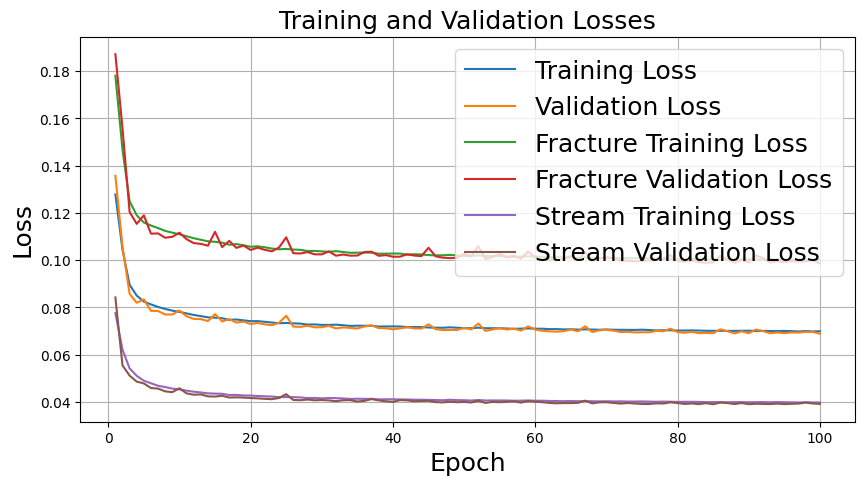

In [16]:
### PLOTTING LOSS CURVES ###

losses_path = 'train_losses_batch_16.pt'
loss_data = torch.load(losses_path)

train_losses = loss_data['train_loss']
val_losses = loss_data['val_loss']
fracture_train_losses = loss_data['fracture_train_loss']
fracture_val_losses = loss_data['fracture_val_loss']
stream_train_losses = loss_data['stream_train_loss']
stream_val_losses = loss_data['stream_val_loss']

# Create a plot of training and validation losses
epochs = range(1, len(train_losses) + 1)  # Epochs start at 1, not 0

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, fracture_train_losses, label='Fracture Training Loss')
plt.plot(epochs, fracture_val_losses, label='Fracture Validation Loss')
plt.plot(epochs, stream_train_losses, label='Stream Training Loss')
plt.plot(epochs, stream_val_losses, label='Stream Validation Loss')
plt.title('Training and Validation Losses', fontsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.show()

In [11]:
### LOADING MODEL ###
in_channels = 1
out_channels = 2

model = UNet(in_channels, out_channels)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Load the weights
weights_path = 'data/data/model_weights/train_dataset_batch_64_100.pth'
model.load_state_dict(torch.load(weights_path, map_location=device))

# Set to evaluation mode
model.eval()

DataParallel(
  (module): UNet(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [12]:
### PREDICTING WITH MODEL ###

images_train = []
fractures_pred_train = []
fractures_labels_train = []
streams_pred_train = []
streams_labels_train = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_train:
        images = batches["images"].to(device)
        fractures = batches["fractures"].to(device)
        streams = batches["streams"].to(device)
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        #pred_fractures = (pred_fractures > 0.25).float()  # Threshold probabilities to get binary mask
        #pred_streams = (pred_streams > 0.5).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        fractures_labels_train.append(fractures.cpu().numpy())  # Store actual labels
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        streams_labels_train.append(streams.cpu().numpy())
        
        del images, fractures, streams, preds
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
fractures_labels_train = np.vstack(fractures_labels_train)
streams_pred_train = np.vstack(streams_pred_train)
streams_labels_train = np.vstack(streams_labels_train)

#print(f"Training set: images, predictions, and labels acquired, shape: {predictions_train.shape}")

# Repeat for validation set

images_val = []
fractures_pred_val = []
fractures_labels_val = []
streams_pred_val = []
streams_labels_val = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_val:
        images = batches["images"].to(device)
        fractures = batches["fractures"].to(device)
        streams = batches["streams"].to(device)
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        #pred_fractures = (pred_fractures > 0.1).float()  # Threshold probabilities to get binary mask
        #pred_streams = (pred_streams > 0.25).float()
        images_val.append(images.cpu().numpy()) # store images
        fractures_pred_val.append(pred_fractures.cpu().numpy())  # Store predictions
        fractures_labels_val.append(fractures.cpu().numpy())  # Store actual labels
        streams_pred_val.append(pred_streams.cpu().numpy())  # Store predictions
        streams_labels_val.append(streams.cpu().numpy())
        
        del images, fractures, streams, preds
        
images_val = np.vstack(images_val)
fractures_pred_val = np.vstack(fractures_pred_val)
fractures_labels_val = np.vstack(fractures_labels_val)
streams_pred_val = np.vstack(streams_pred_val)
streams_labels_val = np.vstack(streams_labels_val)


In [4]:
from PIL import Image

fracture_img = Image.new('L', (padded_width, padded_height))
stream_img = Image.new('L', (padded_width, padded_height))

print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    fracture_image = Image.fromarray((255 * fractures_pred_train[i, 0, :, :]))
    stream_image = Image.fromarray((255 * streams_pred_train[i, 0, :, :]))
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))
    
#fracture_img.save(f"data/data/maps_from_models/fracture_image_{img_code}.png")
#stream_img.save(f"data/data/maps_from_models/stream_image_{img_code}.png")

NameError: name 'padded_width' is not defined

In [13]:
fractures_pred_train = fractures_pred_train.flatten()
fractures_labels_train = fractures_labels_train.flatten()
streams_pred_train = streams_pred_train.flatten()
streams_labels_train = streams_labels_train.flatten()

fractures_pred_val = fractures_pred_val.flatten()
fractures_labels_val = fractures_labels_val.flatten()
streams_pred_val = streams_pred_val.flatten()
streams_labels_val = streams_labels_val.flatten()

In [14]:
precision, recall, _ = precision_recall_curve(fractures_labels_val, fractures_pred_val)
precision_streams, recall_streams, _ = precision_recall_curve(streams_labels_val, streams_pred_val)

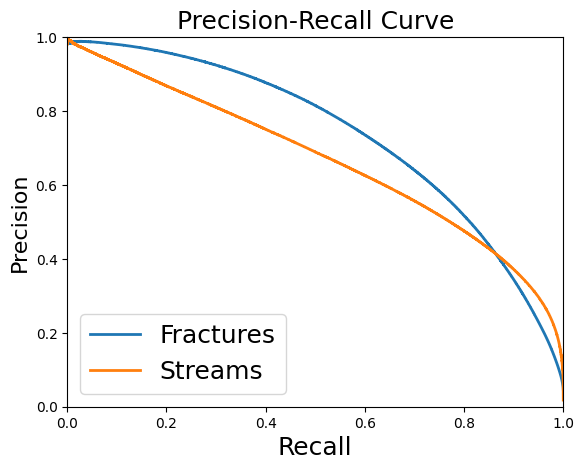

In [17]:
plt.plot(recall, precision, lw=2, label="Fractures")
plt.plot(recall_streams, precision_streams, lw=2, label="Streams")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize = 18)
plt.ylabel('Precision', fontsize = 16)
plt.title('Precision-Recall Curve', fontsize = 18)
plt.legend(fontsize=18)
plt.show()

In [ ]:
#fracture_threshold = (fractures_pred_val > threshold)

cm = confusion_matrix(streams_labels_train, streams_pred_train, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
# Set the title
#ax.set_title(f"Fracture Val Confusion Matrix: {threshold}")
plt.show()

In [ ]:

cm = confusion_matrix(fractures_labels_val, fractures_pred_val, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
# Set the title
#ax.set_title(f"Fracture Val Confusion Matrix: {threshold}")
plt.show()

In [ ]:
cm = confusion_matrix(fractures_labels_train, fractures_pred_train, labels=[0, 1])
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
# Set the title
#ax.set_title(f"Fracture Val Confusion Matrix: {threshold}")
plt.show()

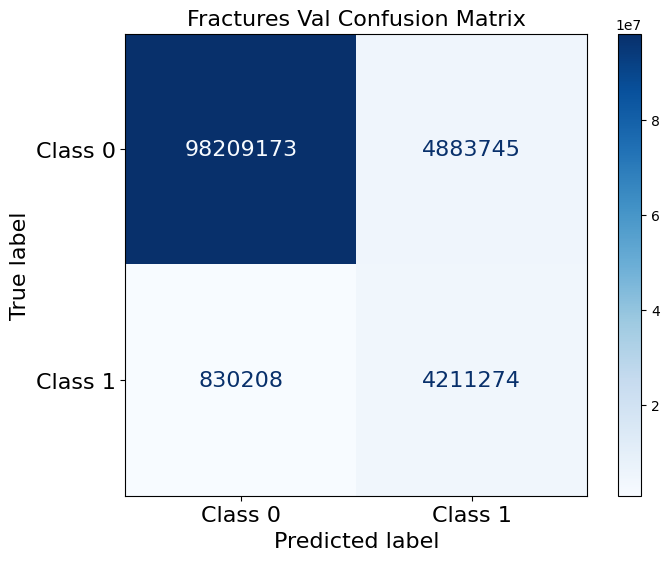

In [26]:
thresholds = [0.1]
for threshold in thresholds:
    fractures_threshold = (fractures_pred_val > threshold)

    # Generate confusion matrix
    cm = confusion_matrix(fractures_labels_val, fractures_threshold, labels=[0, 1])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f"Fractures Val Confusion Matrix", fontsize=16)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.tick_params(axis='both', labelsize=16)
    for text in ax.texts:  # Use ax.texts to access annotations
        text.set_fontsize(16)

In [34]:
fractures_pred_train = fractures_pred_train.flatten()
fractures_labels_train = fractures_labels_train.flatten()
streams_pred_train = streams_pred_train.flatten()
streams_labels_train = streams_labels_train.flatten()

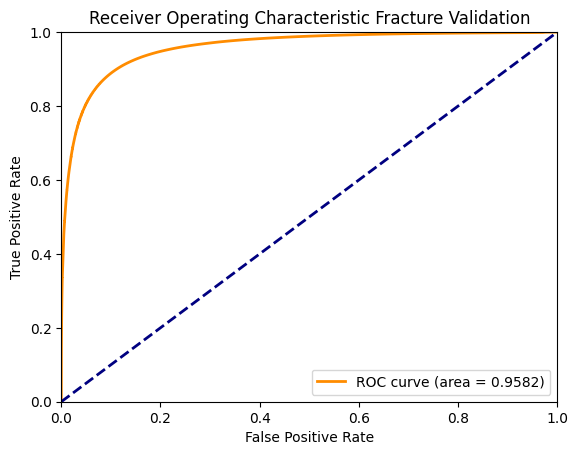

AUC =  0.9581615990684065


In [47]:
### ROC CURVE ###

'''
print('prediction maximum value:',max(fractures_pred_train))
print('prediction minimum value:',min(fractures_pred_train))
print('label maximum value:',max(fractures_labels_train))
print('label minimum value:',min(fractures_labels_train))
print('label shape:', fractures_labels_train.shape)
print('prediction shape:',fractures_pred_train.shape)
'''

fpr, tpr, thresholds = roc_curve(fractures_labels_val, fractures_pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw=lw, linestyle = '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Fracture Validation')
plt.legend(loc = 'lower right')
plt.show()
print('AUC = ',roc_auc)

(11543, 1, 256, 256)
(11543, 1, 256, 256)
(11543, 1, 256, 256)


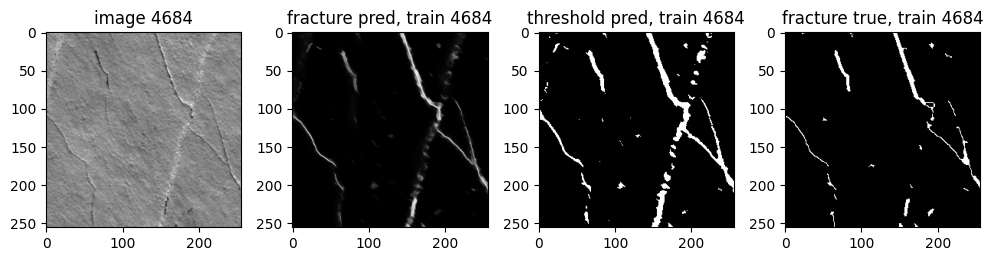

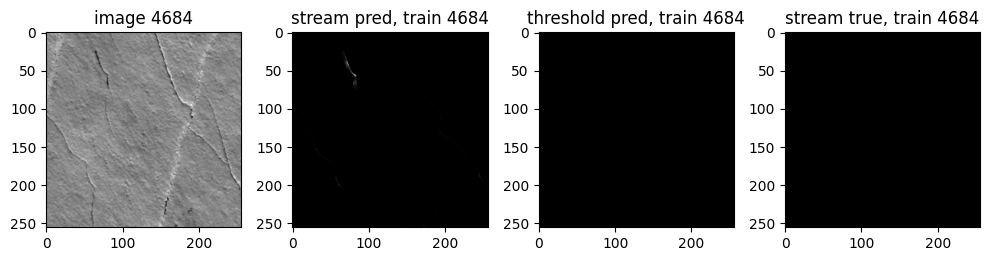

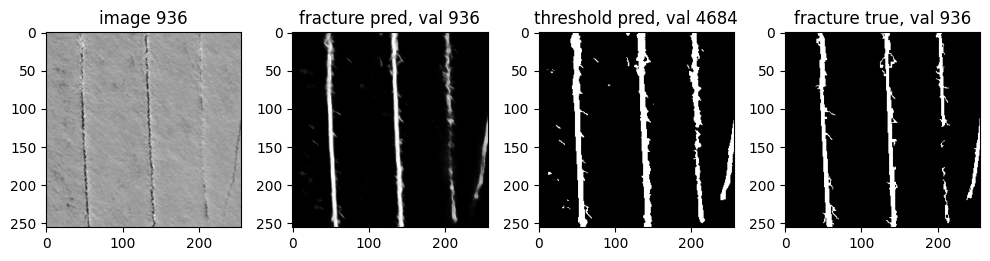

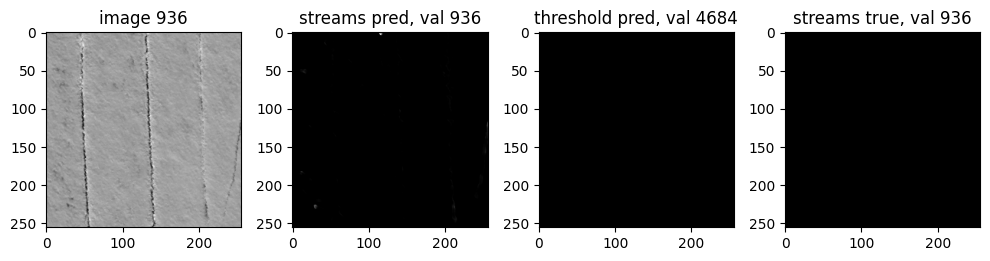

In [8]:
### PLOTTING IMAGES ###

idx_train = random.randint(0,len(fractures_labels_train))
threshold_fractures = 0.1
threshold_streams = 0.25
#idx_train = 627

print(fractures_labels_train.shape)
print(fractures_pred_train.shape)
print(images_train.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(fractures_pred_train[idx_train,0,:,:],cmap='gray')
plt.title(f'fracture pred, train {idx_train}')
plt.subplot(1,4,3)
thresholded = (fractures_pred_train[idx_train,0,:,:] > threshold_fractures).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, train {idx_train}')
plt.subplot(1,4,4)
plt.imshow(fractures_labels_train[idx_train,0,:,:],cmap='gray')
plt.title(f'fracture true, train {idx_train}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(streams_pred_train[idx_train,0,:,:],cmap='gray')
plt.title(f'stream pred, train {idx_train}')
plt.subplot(1,4,3)
thresholded = (streams_pred_train[idx_train,0,:,:] > threshold_streams).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, train {idx_train}')
plt.subplot(1,4,4)
plt.imshow(streams_labels_train[idx_train,0,:,:],cmap='gray')
plt.title(f'stream true, train {idx_train}')
plt.tight_layout()
plt.show()


# validation images:
idx_val = random.randint(0,len(fractures_labels_val))
#idx_val = 83

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_val}')
plt.imshow(images_val[idx_val,0,:,:], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(fractures_pred_val[idx_val,0,:,:],cmap='gray')
plt.title(f'fracture pred, val {idx_val}')
plt.subplot(1,4,3)
thresholded = (fractures_pred_val[idx_val,0,:,:] > threshold_fractures).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, val {idx_train}')
plt.subplot(1,4,4)
plt.imshow(fractures_labels_val[idx_val,0,:,:],cmap='gray')
plt.title(f'fracture true, val {idx_val}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1,4,1)
plt.title(f'image {idx_val}')
plt.imshow(images_val[idx_val,0,:,:], cmap='gray')
plt.subplot(1,4,2)
plt.imshow(streams_pred_val[idx_val,0,:,:],cmap='gray')
plt.title(f'streams pred, val {idx_val}')
plt.subplot(1,4,3)
thresholded = (streams_pred_val[idx_val,0,:,:] > threshold_streams).astype(float)
plt.imshow(thresholded,cmap='gray')
plt.title(f'threshold pred, val {idx_train}')
plt.subplot(1,4,4)
plt.imshow(streams_labels_val[idx_val,0,:,:],cmap='gray')
plt.title(f'streams true, val {idx_val}')
plt.tight_layout()
plt.show()


In [27]:
### METRIC DEFINITIONS ###

def calculate_accuracy(true, pred):
    
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    accuracy = accuracy_score(true_flat, pred_flat)
    
    return accuracy

def calculate_f1(true, pred):
    
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    f1 = f1_score(true_flat, pred_flat, zero_division=1)
    
    return f1

def calculate_recall(true, pred):
    
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    recall = recall_score(true_flat, pred_flat, zero_division=1)
    
    return recall

def evaluate_accuracy(labels, predictions):
    accuracies = []

    for i in range(predictions.shape[0]):
        accuracy = calculate_accuracy(labels[i, 0, :, :], predictions[i, 0, :, :])
        accuracies.append(accuracy)
    
    return accuracies

def f1_threshold(labels, predictions, labels_2, predictions_2, thresholds):
    avg_f1s = []
    
    for threshold in thresholds:
        predictions_threshold = (predictions > threshold).astype(float)
        predictions_2_threshold = (predictions_2 > threshold).astype(float)
        f1s = []
        
        for i in range(predictions.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                f1 = calculate_f1(labels[i, 0, :, :], predictions_threshold[i, 0, :, :])
                f1s.append(f1)

        for j in range(predictions_2.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                f1 = calculate_f1(labels_2[j, 0, :, :], predictions_2_threshold[j, 0, :, :])
                f1s.append(f1)
        print(len(f1s))
        
        avg_f1s.append(np.mean(f1s))
        
        plt.figure(figsize=(15, 10))
        plt.hist(f1s, bins=20, color='blue', alpha=0.7)
        plt.title(f'F1 Score Distribution {threshold}')
        plt.xlabel('F1 Score')
        plt.ylabel('Frequency')
    
    return avg_f1s

def recall_threshold(labels, predictions, labels_2, predictions_2, thresholds):
    avg_recalls = []
    
    for threshold in thresholds:
        predictions_threshold = (predictions > threshold).astype(float)
        predictions_2_threshold = (predictions_2 > threshold).astype(float)
        recalls = []
        
        for i in range(predictions.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                recall = calculate_recall(labels[i, 0, :, :], predictions_threshold[i, 0, :, :])
                recalls.append(recall)

        for j in range(predictions_2.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                recall = calculate_recall(labels_2[j, 0, :, :], predictions_2_threshold[j, 0, :, :])
                recalls.append(recall)
        print(len(recalls))
        
        avg_recalls.append(np.mean(recalls))
        
        plt.figure(figsize=(5, 5))
        plt.hist(recalls, bins=20, color='blue', alpha=0.7)
        plt.title(f'Recall Score Distribution {threshold}')
        plt.xlabel('Recall Score')
        plt.ylabel('Frequency')
    
    return avg_recalls


def accuracy_threshold(labels, predictions, labels_2, predictions_2, thresholds):
    avg_accuracy = []
    
    for threshold in thresholds:
        predictions_threshold = (predictions > threshold).astype(float)
        predictions_2_threshold = (predictions_2 > threshold).astype(float)
        accuracies = []
        
        for i in range(predictions.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                accuracy = calculate_accuracy(labels[i, 0, :, :], predictions_threshold[i, 0, :, :])
                accuracies.append(accuracy)

        for j in range(predictions_2.shape[0]):
            if np.mean(labels[i, 0, :, :]) != 0:
                accuracy = calculate_accuracy(labels_2[j, 0, :, :], predictions_2_threshold[j, 0, :, :])
                accuracies.append(accuracy)
        
        avg_accuracy.append(np.mean(accuracies))
        
        plt.figure(figsize=(15, 10))
        plt.hist(accuracies, bins=20, color='blue', alpha=0.7)
        plt.title(f'Accuracy Score Distribution {threshold}')
        plt.xlabel('Accuracy Score')
        plt.ylabel('Frequency')
    
    return avg_accuracy

In [ ]:
print(fractures_labels_val[3])
print(fractures_pred_val[3])
calculate_accuracy(fractures_labels_val[3], fractures_pred_val[3])

In [33]:
### GETTING METRICS ###
fracture_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
stream_thresholds = [0.2, 0.3, 0.4, 0.5, 0.6]

print(len(fractures_labels_train))

fractures_train_metrics = evaluate_accuracy(fractures_labels_train, fractures_pred_train)
print(f"Fractures training set metrics: Accuracy Mean: {np.mean(fractures_train_metrics)}, Accuracy Median: {np.median(fractures_train_metrics)}, Accuracy Std: {np.std(fractures_train_metrics)}")

streams_train_metrics = evaluate_accuracy(streams_labels_train, streams_pred_train)
print(f"Streams training set metrics: Accuracy Mean: {np.mean(streams_train_metrics)}, Accuracy Median: {np.median(streams_train_metrics)}, Accuracy Std: {np.std(streams_train_metrics)}")

fractures_val_metrics = evaluate_accuracy(fractures_labels_val, fractures_pred_val)
print(f"Fractures training set metrics: Accuracy Mean: {np.mean(fractures_val_metrics)}, Accuracy Median: {np.median(fractures_val_metrics)}, Accuracy Std: {np.std(fractures_val_metrics)}")

streams_val_metrics = evaluate_accuracy(streams_labels_val, streams_pred_val)
print(f"Streams training set metrics: Accuracy Mean: {np.mean(streams_val_metrics)}, Accuracy Median: {np.median(streams_val_metrics)}, Accuracy Std: {np.std(streams_val_metrics)}")

'''
fractures_train_f1 = f1_threshold(fractures_labels_train, fractures_pred_train, fractures_labels_val, fractures_pred_val, fracture_thresholds)
print(fractures_train_f1, fracture_thresholds)
#print(f"Fractures training set metrics: f1 Mean: {np.mean(fractures_train_f1)}, f1 Median: {np.median(fractures_train_f1)}, f1 Std: {np.std(fractures_train_f1)}")


streams_train_f1 = f1_threshold(streams_labels_train, streams_pred_train, streams_labels_val, streams_pred_val, stream_thresholds)
print(streams_train_f1, stream_thresholds)
#print(f"Streams training set metrics: f1 Mean: {np.mean(streams_trainf1)}, f1 Median: {np.median(streams_trainf1)}, f1 Std: {np.std(streams_trainf1)}")


fractures_val_metrics = evaluate_accuracy(fractures_labels_val, fractures_pred_val)
print(f"Fractures validation set metrics: Accuracy Mean: {np.mean(fractures_val_metrics)}, Accuracy Median: {np.median(fractures_val_metrics)}, Accuracy Std: {np.std(fractures_val_metrics)}")

streams_val_metrics = evaluate_accuracy(streams_labels_val, streams_pred_val)
print(f"Streams validation set metrics: Accuracy Mean: {np.mean(streams_val_metrics)}, Accuracy Median: {np.median(streams_val_metrics)}, Accuracy Std: {np.std(streams_val_metrics)}")


fractures_train_recall = recall_threshold(fractures_labels_train, fractures_pred_train, fractures_labels_val, fractures_pred_val, fracture_thresholds)
print(fractures_train_recall, fracture_thresholds)

streams_train_recall = recall_threshold(streams_labels_train, streams_pred_train, streams_labels_val, streams_pred_val, stream_thresholds)
print(streams_train_recall, stream_thresholds)
'''

3299
Fractures training set metrics: Accuracy Mean: 0.9595768498666144, Accuracy Median: 0.964263916015625, Accuracy Std: 0.029630655408420428
Streams training set metrics: Accuracy Mean: 0.984785493340193, Accuracy Median: 0.9987030029296875, Accuracy Std: 0.025350395510157688
Fractures training set metrics: Accuracy Mean: 0.9607183560458097, Accuracy Median: 0.9654312133789062, Accuracy Std: 0.028239082909497625
Streams training set metrics: Accuracy Mean: 0.9844616514263731, Accuracy Median: 0.9984588623046875, Accuracy Std: 0.02502400529660837


'\nfractures_train_f1 = f1_threshold(fractures_labels_train, fractures_pred_train, fractures_labels_val, fractures_pred_val, fracture_thresholds)\nprint(fractures_train_f1, fracture_thresholds)\n#print(f"Fractures training set metrics: f1 Mean: {np.mean(fractures_train_f1)}, f1 Median: {np.median(fractures_train_f1)}, f1 Std: {np.std(fractures_train_f1)}")\n\n\nstreams_train_f1 = f1_threshold(streams_labels_train, streams_pred_train, streams_labels_val, streams_pred_val, stream_thresholds)\nprint(streams_train_f1, stream_thresholds)\n#print(f"Streams training set metrics: f1 Mean: {np.mean(streams_trainf1)}, f1 Median: {np.median(streams_trainf1)}, f1 Std: {np.std(streams_trainf1)}")\n\n\nfractures_val_metrics = evaluate_accuracy(fractures_labels_val, fractures_pred_val)\nprint(f"Fractures validation set metrics: Accuracy Mean: {np.mean(fractures_val_metrics)}, Accuracy Median: {np.median(fractures_val_metrics)}, Accuracy Std: {np.std(fractures_val_metrics)}")\n\nstreams_val_metrics = 

Text(0, 0.5, 'Stream Accuracy')

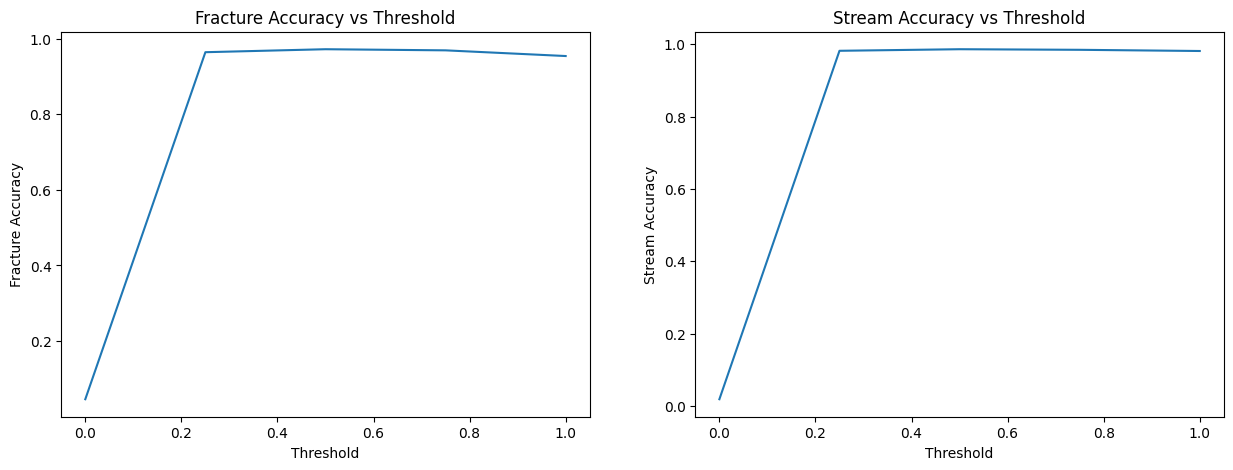

In [24]:
# thresholds = [0, 0.25, 0.5, 0.75, 1]
# accuracy_fracture = [0.04630594420521595, 0.9638296043611698, 0.971707082306165, 0.9687241746758906, 0.9536942998336299]
# accuracy_stream = [0.018341271481340127, 0.9822392552957772, 0.9865815680156943, 0.9849587675204624, 0.9816587285186599]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(thresholds, accuracy_fracture)
plt.title('Fracture Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Fracture Accuracy')

plt.subplot(1, 2, 2)
plt.plot(thresholds, accuracy_stream)
plt.title('Stream Accuracy vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Stream Accuracy')

Text(0, 0.5, 'Stream Accuracy')

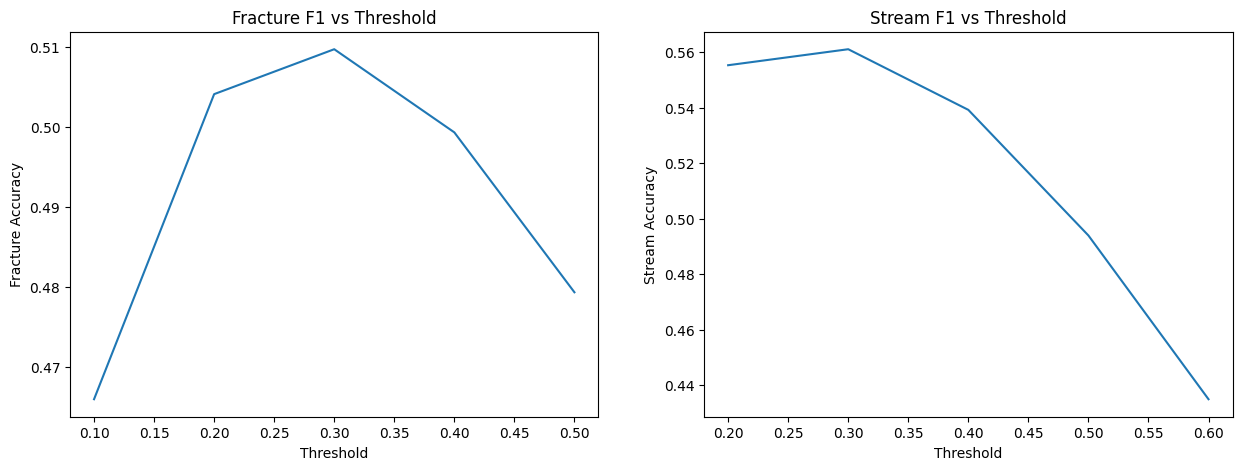

In [12]:
# f1_fracture = [0.10261707175178351, 0.509255267801566, 0.4793031705203553, 0.3691817516882442, 0.02941446824156632]
# f1_streams = [0.07636337160531545, 0.5621489769627122, 0.49389048434408866, 0.3018172651865805, 0.0]
fracture_threshold = [0.1, 0.2, 0.3, 0.4, 0.5]
f1_fracture = [0.4659217602137158, 0.5040928215576873, 0.5097130234004847, 0.49931001367614236, 0.4793031705203553]
stream_threshold = [0.2, 0.3, 0.4, 0.5, 0.6]
f1_streams = [0.5552350117202108, 0.5610011363415773, 0.5391537778942999, 0.49389048434408866, 0.43489541729939946]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(fracture_threshold, f1_fracture)
plt.title('Fracture F1 vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Fracture Accuracy')

plt.subplot(1, 2, 2)
plt.plot(stream_threshold, f1_streams)
plt.title('Stream F1 vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Stream Accuracy')

Text(0, 0.5, 'Stream Recall')

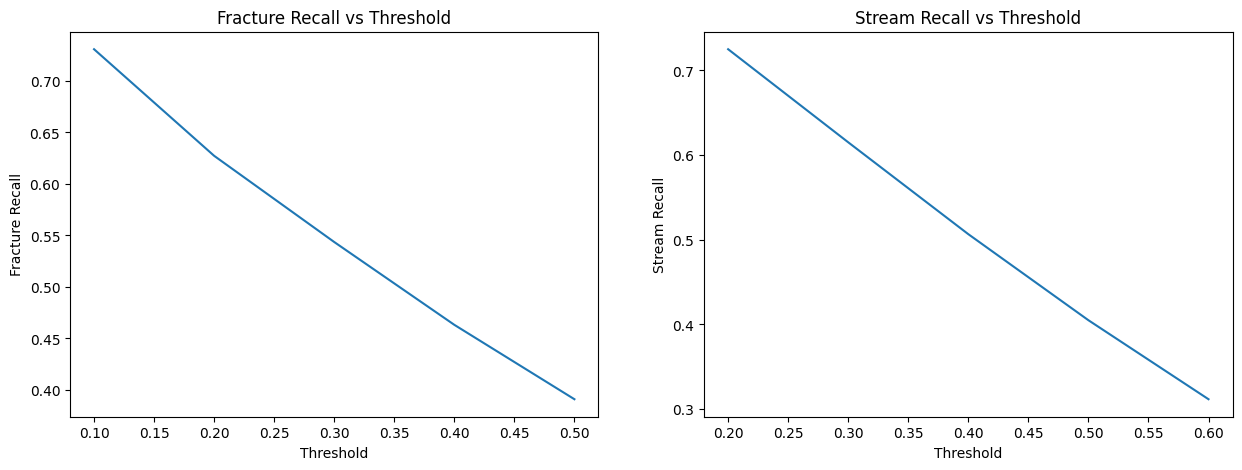

In [13]:
#recall_fracture = [1.0, 0.5847343110113902, 0.39094960445112614, 0.2395108111811052, 0.02941446824156632]
#recall_streams = [1.0, 0.6699494263687518, 0.40496821015910506, 0.17800675076630582, 0.0]
recall_fracture = [0.7308714392077816, 0.627352826666632, 0.5436237550152341, 0.46320462804347773, 0.39094960445112614]
recall_streams = [0.7250915012315726, 0.6151351598875392, 0.5066062770186275, 0.40496821015910517, 0.31164698585908995]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(fracture_threshold, recall_fracture)
plt.title('Fracture Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Fracture Recall')

plt.subplot(1, 2, 2)
plt.plot(stream_threshold, recall_streams)
plt.title('Stream Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Stream Recall')

0.47103306238845943
0.5252076293811455


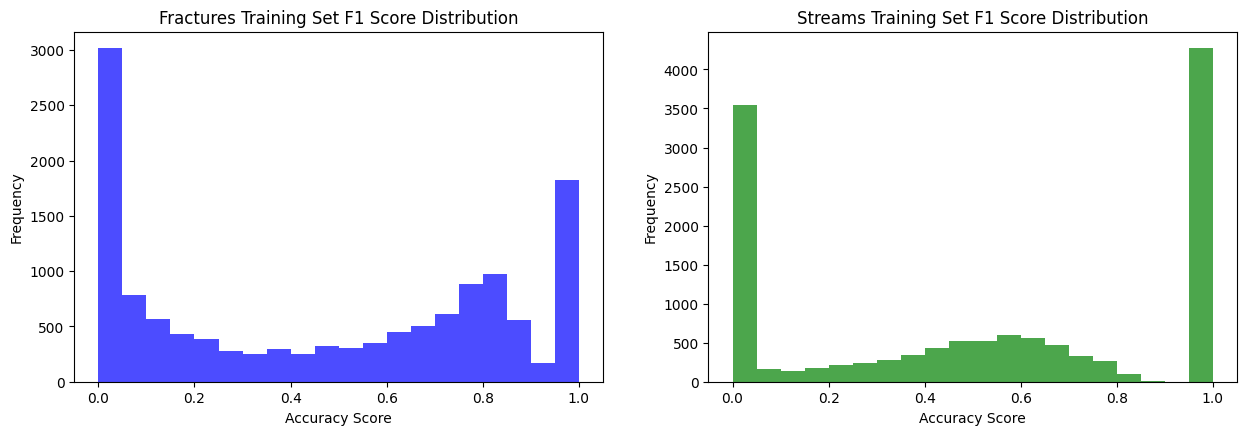

In [16]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(fractures_train_f1, bins=20, color='blue', alpha=0.7)
plt.title('Fractures Training Set F1 Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(streams_trainf1, bins=20, color='green', alpha=0.7)
plt.title('Streams Training Set F1 Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

print(np.mean(fractures_train_f1))
print(np.mean(streams_trainf1))

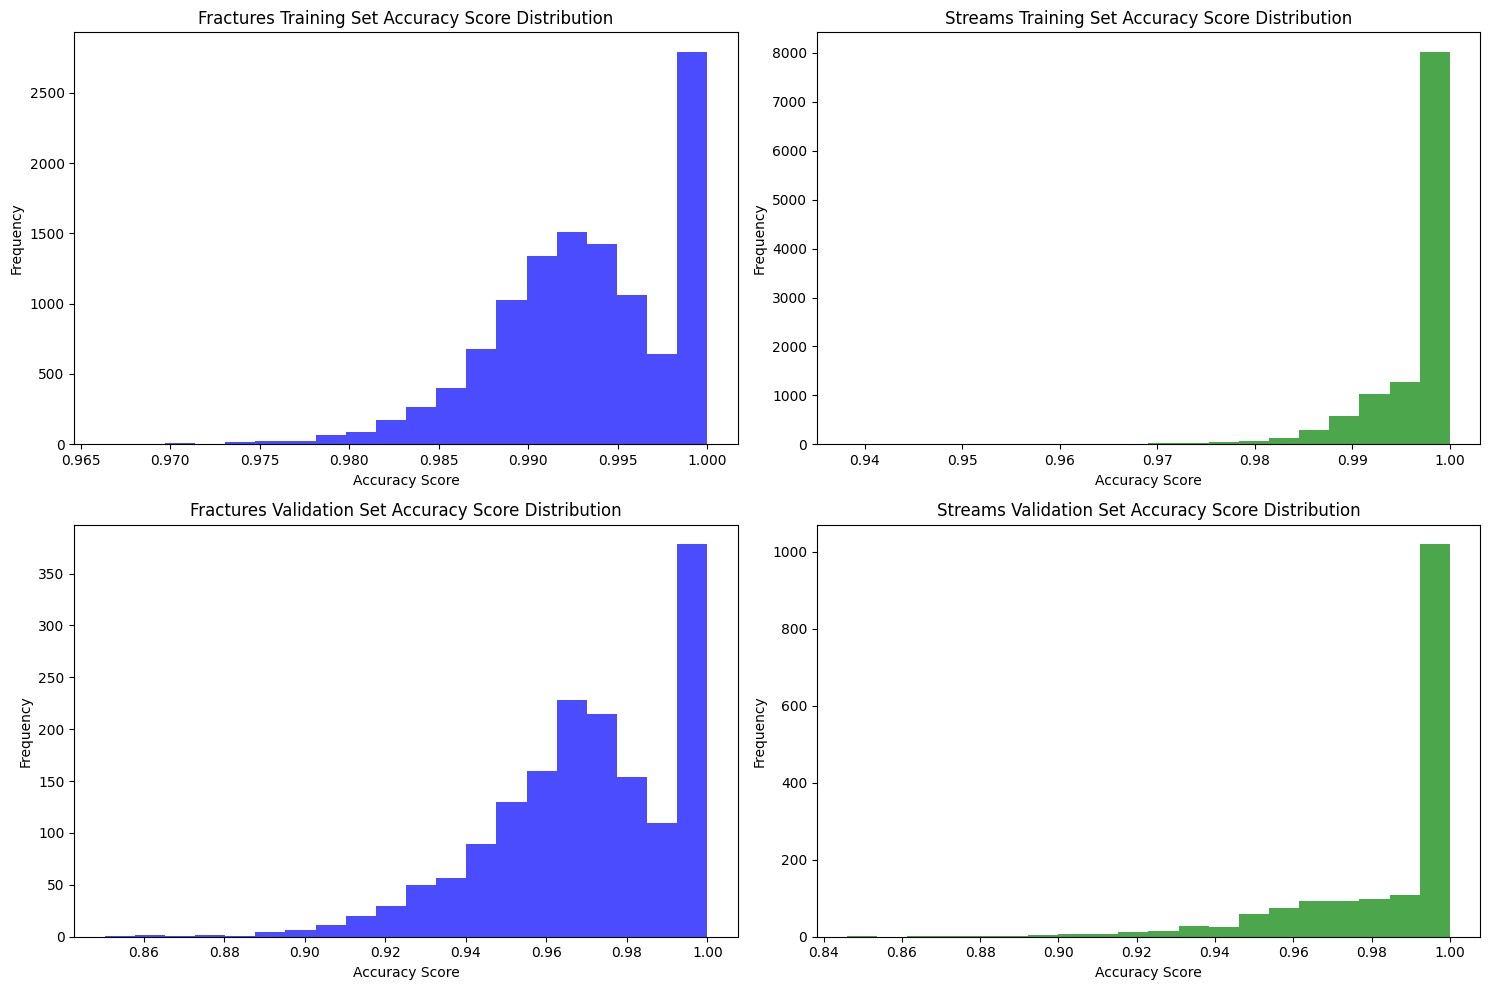

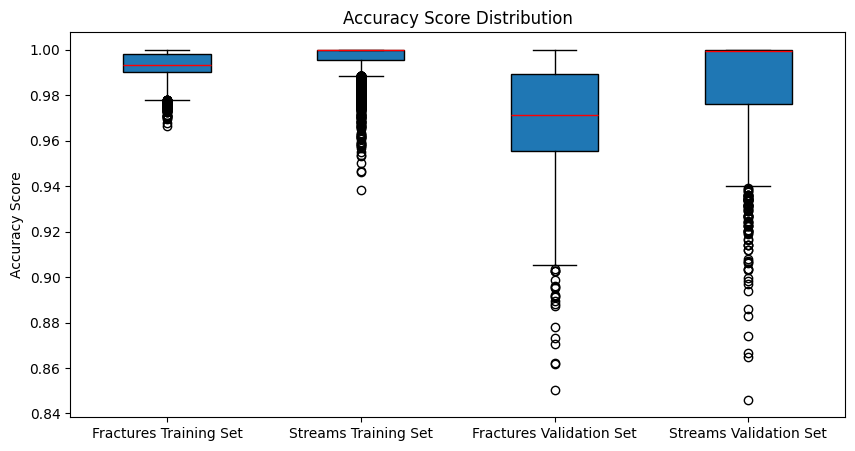

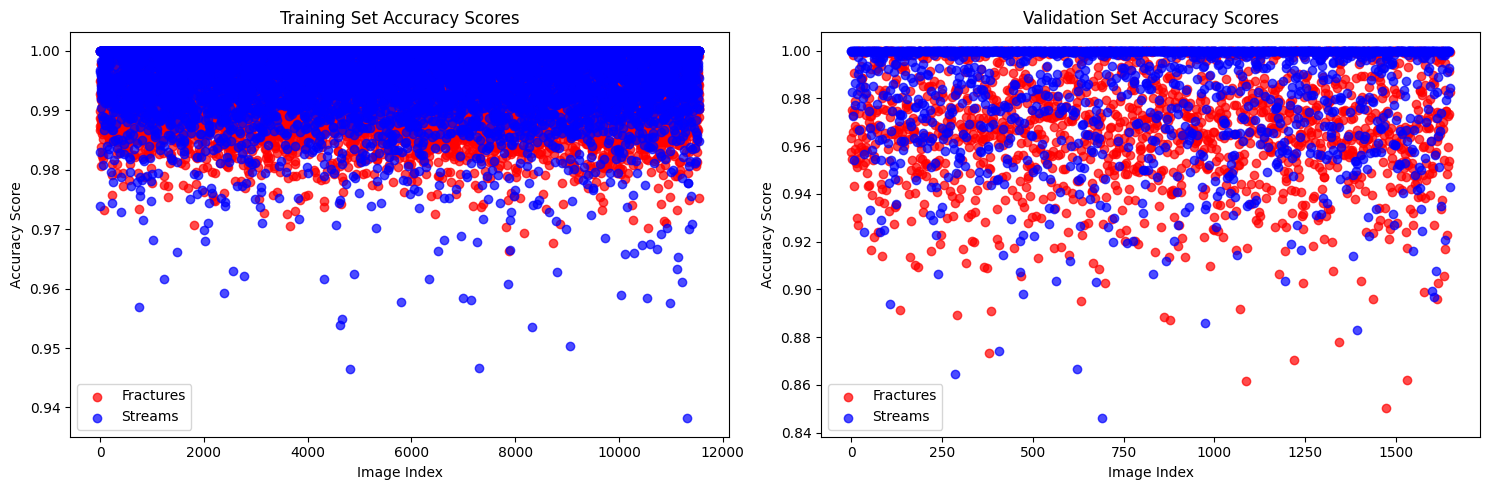

In [30]:
### SEGMENTATION METRIC PLOTS ###

# Plotting histograms of IoU scores
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(fractures_train_metrics, bins=20, color='blue', alpha=0.7)
plt.title('Fractures Training Set Accuracy Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(streams_train_metrics, bins=20, color='green', alpha=0.7)
plt.title('Streams Training Set Accuracy Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(fractures_val_metrics, bins=20, color='blue', alpha=0.7)
plt.title('Fractures Validation Set Accuracy Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(streams_val_metrics, bins=20, color='green', alpha=0.7)
plt.title('Streams Validation Set Accuracy Score Distribution')
plt.xlabel('Accuracy Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plotting box plots of IoU scores
plt.figure(figsize=(10, 5))

# Box plot for training and validation IoU scores
plt.boxplot([fractures_train_metrics, streams_train_metrics, fractures_val_metrics, streams_val_metrics],
            labels=['Fractures Training Set', 'Streams Training Set', 'Fractures Validation Set', 'Streams Validation Set'],
            patch_artist=True,
            medianprops=dict(color='red'))

plt.title('Accuracy Score Distribution')
plt.ylabel('Accuracy Score')
plt.show()

# Plotting scatter plots of IoU scores
plt.figure(figsize=(15, 5))

# Scatter plot for training set IoU scores
plt.subplot(1, 2, 1)
plt.scatter(range(len(fractures_train_metrics)), fractures_train_metrics, label = 'Fractures', color='red', alpha=0.7)
plt.scatter(range(len(streams_train_metrics)), streams_train_metrics, label = 'Streams', color='blue', alpha=0.7)
plt.legend()
plt.title('Training Set Accuracy Scores')
plt.xlabel('Image Index')
plt.ylabel('Accuracy Score')

# Scatter plot for validation set IoU scores
plt.subplot(1, 2, 2)
plt.scatter(range(len(fractures_val_metrics)), fractures_val_metrics, color='red', label = 'Fractures', alpha=0.7)
plt.scatter(range(len(streams_val_metrics)), streams_val_metrics, color='blue', label = 'Streams', alpha=0.7)
plt.legend()
plt.title('Validation Set Accuracy Scores')
plt.xlabel('Image Index')
plt.ylabel('Accuracy Score')

plt.tight_layout()
plt.show()


In [62]:
for idx in range(len(streams_val_metrics)):
    if fractures_train_metrics[idx] < 0.88:
        print(idx, fractures_train_metrics[idx])

57 0.8722076416015625
627 0.85797119140625
859 0.862518310546875
873 0.874664306640625
1152 0.87890625
1422 0.8737640380859375
1463 0.7888946533203125
1467 0.876953125
1569 0.8777618408203125
